# BERT-base (FROZEN, no fine-tuning)


In [1]:
print("Importing necessary libraries...\n")

import datasets
import re
import requests
import nltk
import sklearn
import torch
import random

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from nltk import word_tokenize, FreqDist, pos_tag

from sklearn import linear_model, metrics

from sklearn.feature_extraction.text import *

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, f1_score, recall_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import uniform, randint
from sklearn.linear_model import LogisticRegression


from transformers import AutoTokenizer, AutoModel


from typing import Any, Dict, Iterable, List, Optional, Set, Tuple

import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from xgboost import XGBClassifier

# Might be necessary
nltk.download('punkt_tab', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
nltk.download('universal_tagset', quiet=True)

# Set the Seeds
SEED = 42
random.seed(SEED)

np.random.seed(SEED)

torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Set the Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("WARNING: no GPU detected; training may be slow")
print("\nDone!")

Importing necessary libraries...

Using device: cpu

Done!


In [2]:
# Load and Split Data
data_df = pd.read_csv('Phishing_Email.csv')
train_size = .8
validation_size = .1
test_size = .1

# Uses global Seed for random_state
train_df, temp_df = train_test_split(data_df, train_size = train_size, random_state= SEED)
validation_df, test_df = train_test_split(temp_df, test_size=.5, random_state= SEED)

# Configure Pandas Display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 70)
pd.set_option('display.expand_frame_rep', False)


print("Training Data shape:", train_df.shape)
print("Validation Data shape:", validation_df.shape)
print("Testing Data shape:", test_df.shape)
print()
print("Below is a small sample of what the data we will be using looks like:")

sample_phishing = train_df[train_df['Email Type'] == 'Phishing Email'].sample(n=3, random_state=SEED)
sample_safe = train_df[train_df['Email Type'] == 'Safe Email'].sample(n=3, random_state=SEED)

print(pd.concat([sample_phishing, sample_safe]))

Training Data shape: (14920, 3)
Validation Data shape: (1865, 3)
Testing Data shape: (1865, 3)

Below is a small sample of what the data we will be using looks like:
      Unnamed: 0                                                             Email Text      Email Type
6199        6199  sorry , one more thing cheating adult personals get laid now . rea...  Phishing Email
5658        5658  payment representative dear sir / madam , i am mr . liu peijin , m...  Phishing Email
5466        5466  When Economy goes down, WE go UP !$3000 COMMISSION per Sale for YO...  Phishing Email
7321        7322  fifth annual graduate romanic association at the u . of penn . * *...      Safe Email
3140        3140  december conference preliminary announcement first international w...      Safe Email
3510        3510  re : term project : brian , no problem . vince " brian corbett nel...      Safe Email


## Prepare text + labels

In [3]:
def stratified_downsample(df, n, label_col="Email Type", seed=SEED):
    if n >= len(df):
        return df.copy()

    small_df, _ = train_test_split(
        df,
        train_size=n,
        stratify=df[label_col],
        random_state=seed
    )
    return small_df.reset_index(drop=True)

train_df_small = stratified_downsample(train_df, 6000)
validation_df_small = stratified_downsample(validation_df, 1000)
test_df_small = stratified_downsample(test_df, 1000)

print("Reduced Training shape:", train_df_small.shape)
print("Reduced Validation shape:", validation_df_small.shape)
print("Reduced Testing shape:", test_df_small.shape)

Reduced Training shape: (6000, 3)
Reduced Validation shape: (1000, 3)
Reduced Testing shape: (1000, 3)


In [4]:
# Train on Subset of Data # 
train_email_text_small = train_df_small["Email Text"].fillna("").tolist()
validation_email_text_small = validation_df_small["Email Text"].fillna("").tolist()

print("train_email_text_small shape:", len(train_email_text_small))
print("validation_email_text_small shape:", len(validation_email_text_small))
# Entire Data
train_email_text = train_df["Email Text"].fillna("").tolist()
validation_email_text = validation_df["Email Text"].fillna("").tolist()

print("train_email_text shape:", len(train_email_text))
print("validation_email_text shape:", len(validation_email_text))

print("Encoding email labels as binary values (1 = phishing, 0 = safe)\n")
Y_train = (train_df["Email Type"] == "Phishing Email").astype(int)
Y_val = (validation_df["Email Type"] == "Phishing Email").astype(int)

train_email_text_small shape: 6000
validation_email_text_small shape: 1000
train_email_text shape: 14920
validation_email_text shape: 1865
Encoding email labels as binary values (1 = phishing, 0 = safe)



## BERT embedding function

In [5]:
MODEL_NAME = "bert-base-uncased"
MAX_LEN = 256 # 256 is better if you have GPU
BATCH_SIZE = 16

def bert_embed_texts(texts, tokenizer, model, device):
    """
    Returns one vector per text using mean pooling over token embeddings.
    BERT is frozen (no gradient updates).
    """
    all_vecs = []
    model.eval()

    with torch.no_grad():
        for i in range(0, len(texts), BATCH_SIZE):
            batch = texts[i:i+BATCH_SIZE]
            enc = tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=MAX_LEN,
                return_tensors="pt"
            )
            input_ids = enc["input_ids"].to(device)
            attention_mask = enc["attention_mask"].to(device)

            out = model(input_ids=input_ids, attention_mask=attention_mask)
            token_embeddings = out.last_hidden_state  # (B, T, H)

            mask = attention_mask.unsqueeze(-1).float()  # (B, T, 1)
            summed = (token_embeddings * mask).sum(dim=1)     # (B, H)
            counts = mask.sum(dim=1).clamp(min=1e-9)          # (B, 1)
            mean_pooled = summed / counts                     # (B, H)

            all_vecs.append(mean_pooled.cpu().numpy())

    return np.vstack(all_vecs)


## Run the BERT-feature + Logistic Regression baseline

In [6]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert = AutoModel.from_pretrained(MODEL_NAME).to(device)

# Freeze BERT (Level 1)
for p in bert.parameters():
    p.requires_grad = False

X_train_bert = bert_embed_texts(train_email_text, tokenizer, bert, device)
X_val_bert   = bert_embed_texts(validation_email_text, tokenizer, bert, device)

y_train = Y_train.to_numpy()
y_val   = Y_val.to_numpy()

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train_bert, y_train)

val_pred = clf.predict(X_val_bert)
val_proba = clf.predict_proba(X_val_bert)[:, 1]

print("BERT-feature Validation Accuracy:", accuracy_score(y_val, val_pred))
print("BERT-feature Validation AUROC:", roc_auc_score(y_val, val_proba))
print(classification_report(y_val, val_pred, digits=4))

BERT-feature Validation Accuracy: 0.960857908847185
BERT-feature Validation AUROC: 0.9927366295355351
              precision    recall  f1-score   support

           0     0.9749    0.9603    0.9676      1134
           1     0.9398    0.9617    0.9506       731

    accuracy                         0.9609      1865
   macro avg     0.9574    0.9610    0.9591      1865
weighted avg     0.9612    0.9609    0.9609      1865



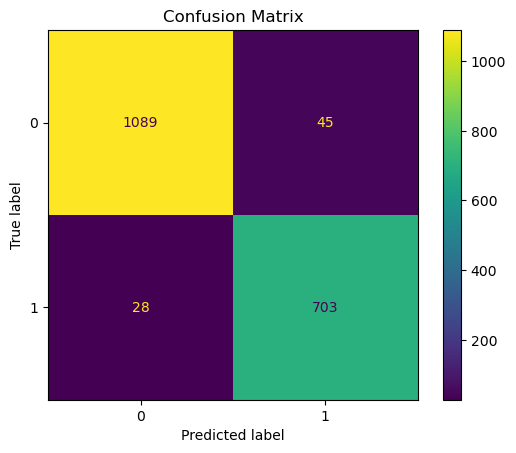

In [7]:
y_pred = clf.predict(X_val_bert)
c_matrix = confusion_matrix(y_val, val_pred)
ConfusionMatrixDisplay(confusion_matrix=c_matrix).plot()
plt.title('Confusion Matrix')
plt.show()

## Save / Load cached embeddings: BERT-base (FROZEN, no fine-tuning) ##

In [8]:
import os

# Clear experimental naming (very important for later)
CACHE_DIR = "bert_base_frozen_no_tuning_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

def save_cache(name: str, arr):
    path = os.path.join(CACHE_DIR, f"{name}.npy")
    np.save(path, arr)
    print(f"Saved: {path}  shape={getattr(arr, 'shape', None)}")

def load_cache(name: str):
    path = os.path.join(CACHE_DIR, f"{name}.npy")
    arr = np.load(path)
    print(f"Loaded: {path}  shape={arr.shape}")
    return arr


# ---- Save embeddings (run after computing X_*_bert) ----
if "X_train_bert" in globals(): save_cache("X_train_bert", X_train_bert)
if "X_val_bert"   in globals(): save_cache("X_val_bert",   X_val_bert)
if "X_test_bert"  in globals(): save_cache("X_test_bert",  X_test_bert)

# Save labels (recommended for reproducibility)
if "y_train" in globals(): save_cache("y_train", np.asarray(y_train))
if "y_val"   in globals(): save_cache("y_val",   np.asarray(y_val))
if "y_test"  in globals(): save_cache("y_test",  np.asarray(y_test))

print("\nBERT (frozen, no fine-tuning) embeddings saved successfully.")


# ===============================
# Example usage later (no recompute):
# ===============================
# X_train_bert = load_cache("X_train_bert")
# X_val_bert   = load_cache("X_val_bert")
# X_test_bert  = load_cache("X_test_bert")
# y_train      = load_cache("y_train")
# y_val        = load_cache("y_val")
# y_test       = load_cache("y_test")


Saved: bert_base_frozen_no_tuning_cache/X_train_bert.npy  shape=(14920, 768)
Saved: bert_base_frozen_no_tuning_cache/X_val_bert.npy  shape=(1865, 768)
Saved: bert_base_frozen_no_tuning_cache/y_train.npy  shape=(14920,)
Saved: bert_base_frozen_no_tuning_cache/y_val.npy  shape=(1865,)

BERT (frozen, no fine-tuning) embeddings saved successfully.


# Example Load and Verify

In [9]:
X_train_check = np.load("bert_base_frozen_no_tuning_cache/X_train_bert.npy")

print("Loaded shape:", X_train_check.shape)

Loaded shape: (14920, 768)


## Run BERT on TEST data (Save for end testing)

In [7]:
# test_email_text = test_df_small["Email Text"].fillna("").tolist()
# y_test = (test_df_small["Email Type"] == "Phishing Email").astype(int).to_numpy()

# X_test_bert = bert_embed_texts(test_email_text, tokenizer, bert, device)

# test_pred = clf.predict(X_test_bert)
# test_proba = clf.predict_proba(X_test_bert)[:, 1]

# print("BERT-feature Test Accuracy:", accuracy_score(y_test, test_pred))
# print("BERT-feature Test AUROC:", roc_auc_score(y_test, test_proba))
# print(classification_report(y_test, test_pred, digits=4))